In [1]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [2]:
import os, glob, shutil
import xml.etree.ElementTree as ET
import datetime
import six
import xarray as xr
import pandas as pd

In [119]:
from stompy.spatial import field
from stompy import utils
import netCDF4
import xarray as xr
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
import matplotlib.pyplot as plt
import logging as log
from scipy.interpolate import griddata
from stompy.spatial import proj_utils
import numpy as np
%matplotlib notebook

In [ ]:
import bloom_common
scene_df = bloom_common.load_chl_scenes()

In [10]:
# Times are always around 18:00, assume that's UTC.
# so mid morning?
scene_df

,xml,acquisition_start,acquisition_stop
0,rs_chl/04b_log10/20220804_BandMath_BandMath.dim,2022-08-04 18:12:01,2022-08-04 18:12:20
1,rs_chl/04b_log10/20220805_BandMath_BandMath.dim,2022-08-05 18:47:14,2022-08-05 18:47:33
2,rs_chl/04b_log10/20220806_BandMath_BandMath.dim,2022-08-06 18:21:23,2022-08-06 18:21:42
3,rs_chl/04b_log10/20220807_BandMath_BandMath.dim,2022-08-07 17:55:28,2022-08-07 17:55:46
4,rs_chl/04b_log10/20220808_BandMath_BandMath.dim,2022-08-08 18:08:18,2022-08-08 18:08:37
5,rs_chl/04b_log10/20220809_BandMath_BandMath.dim,2022-08-09 18:43:32,2022-08-09 18:43:51
6,rs_chl/04b_log10/20220810_BandMath_BandMath.dim,2022-08-10 18:17:41,2022-08-10 18:18:00
7,rs_chl/04b_log10/20220811_BandMath_BandMath.dim,2022-08-11 18:30:30,2022-08-11 18:30:49
8,rs_chl/04b_log10/20220812_BandMath_BandMath.dim,2022-08-12 18:04:36,2022-08-12 18:04:54
9,rs_chl/04b_log10/20220813_BandMath_BandMath.dim,2022-08-13 18:39:52,2022-08-13 18:40:11


In [11]:
from bloom_common import load_scene, load_scene_utm

In [12]:
xyz=load_scene(scene_df['xml'][0])

<IPython.core.display.Javascript object>


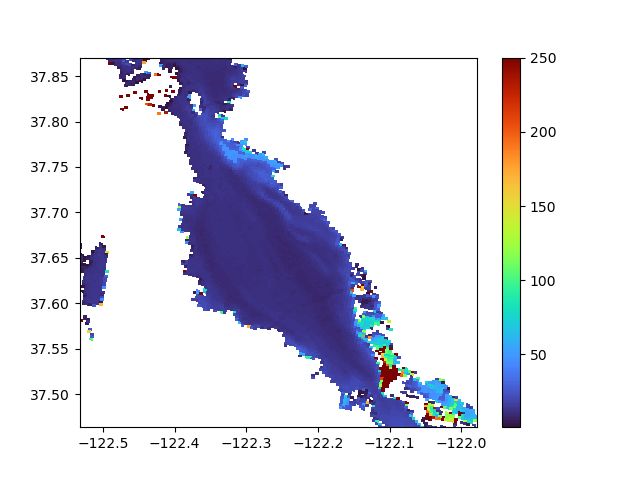

/tmp/ipykernel_2602430/3426222373.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  coll=plt.pcolormesh(xyz[:,:,0], xyz[:,:,1], xyz[:,:,2], cmap='turbo',shading='auto')


In [15]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
coll=plt.pcolormesh(xyz[:,:,0], xyz[:,:,1], xyz[:,:,2], cmap='turbo',shading='auto')
ax.set_aspect(1./np.cos(38*np.pi/180.))
plt.colorbar(coll)
coll.set_clim([1,250])
ax.axis((-122.46512841380759, -122.04521937832382, 37.46384698268398, 37.87026970454546)) ;

In [17]:
if 1: 
    dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_16layer"    
    dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom_16layer")
    hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom_16layer.hyd"))


In [18]:
g=hydro.grid()

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:5121 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary


<IPython.core.display.Javascript object>


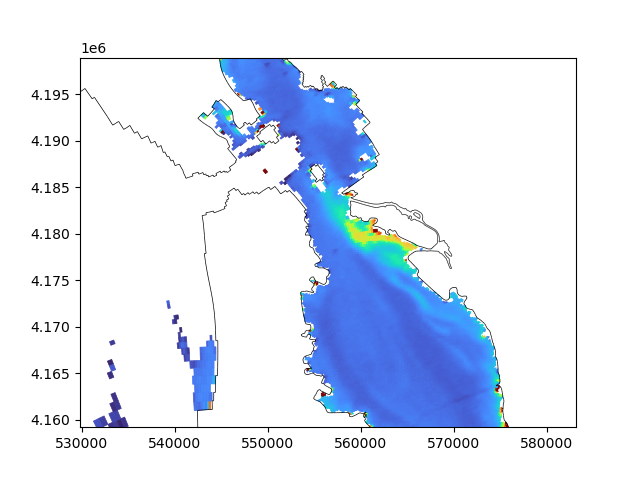

(484269.22705340025, 615692.2318785951, 4134370.722411021, 4236807.203694713)

In [20]:
# Test interpolation onto grid.
utm_xy = proj_utils.mapper("WGS84","EPSG:26910")(xyz[:,:,:2])
# 10s
on_grid=griddata(utm_xy.reshape(-1,2),xyz[...,2].ravel(),g.cells_centroid())

fig,ax=plt.subplots()
#scat=ax.scatter(utm_xy[...,0], utm_xy[...,1], 10, xyz[...,2],cmap='turbo')
#scat.set_clim(0,150)
g.plot_cells(values=on_grid,cmap='turbo',clim=[0,80], edgecolor='face',lw=0.5)
g.plot_boundary(lw=0.5,color='k')
ax.axis('equal')

<IPython.core.display.Javascript object>


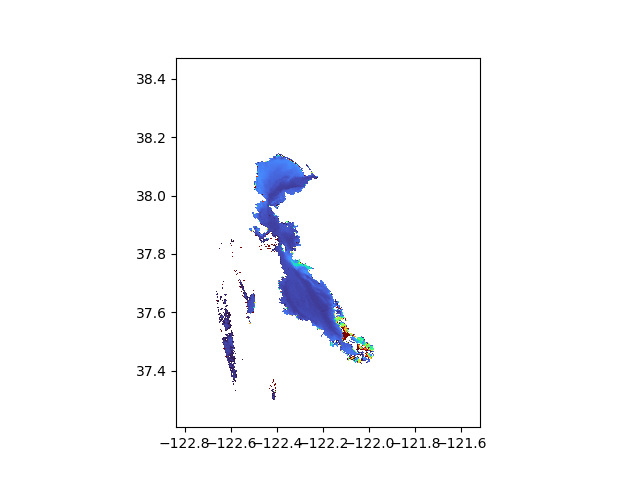

In [21]:
# Alternative approach
# expand pixel center ll to pixel corners
lon_corners,lat_corners=utils.center_to_edge_2d(xyz[:,:,0],xyz[:,:,1])
fig,ax=plt.subplots()
coll=ax.pcolormesh( lon_corners, lat_corners, xyz[...,2],cmap='turbo')
ax.set_aspect(1./np.cos(38*np.pi/180))
coll.set_clim(0,150)

In [198]:
six.moves.reload_module(dwaq)

if 1: # longer, 16 layer run. So far delwaq1 crashes on this one. But recent dwaq should
    # be okay
    dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_16layer"    
    dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom_16layer")
    hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom_16layer.hyd"))

def configure_dwaq_new():
    DELFT_SRC="/opt/software/delft/dfm/2023.01"
    DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
    DELFT_LIB=os.path.join(DELFT_SRC,"lib")

    os.environ['DELFT_SRC']=DELFT_SRC
    os.environ['DELFT_SHARE']=DELFT_SHARE

    # While mucking around with this just clobber whatever was in LD_LIBRARY_PATH
    os.environ['LD_LIBRARY_PATH']=DELFT_LIB
    
def configure_dfm_t140737():
    DELFT_SRC="/opt/software/delft/dfm/t140737"
    DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
    DELFT_LIB=os.path.join(DELFT_SRC,"lib")

    os.environ['DELFT_SRC']=DELFT_SRC
    os.environ['DELFT_SHARE']=DELFT_SHARE

    # While mucking around with this just clobber whatever was in LD_LIBRARY_PATH
    os.environ['LD_LIBRARY_PATH']=f"{DELFT_LIB}:/home/rusty/.conda/envs/dfm_t140737/lib"

#bloom_common.configure_dfm_t140737() # broken for dwaq
bloom_common.configure_dfm_2023_01() # used to be configure_dwaq_new()

class DwaqSetup(object):
    name='dwaq'
    hydro=None
    base_path=None

    force=True # whether to allow re-using an existing run
    
    # start time offset from start of hydro by this delta
    # give it some decent spinup time
    start_time=np.datetime64("2022-08-02 00:00")
    
    # set length of the run. Appears to be the end of valid output, even though the
    # hydro reports going until the 25th.
    stop_time=np.datetime64("2022-08-22 23:00") # seems that even temperature run is dicey on last step
    
    integration_option=24 # if set, copied to WaqModel
    time_step=3000
    map_time_step=3000 # dial this down later, but for now I want to 

    waq_kws={}
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
                
        # round times to the timestep
        self.start_time=utils.round_dt64(self.start_time,self.dt)
        self.stop_time =utils.round_dt64(self.stop_time ,self.dt)
        
        
        if self.base_path is None:
            self.base_path=self.calc_base_path()
                
            # need hour and minute with RS stuff
            yyyymmdd=utils.to_datetime(self.start_time).strftime('%Y%m%dT%H%M')
            self.base_path+="_%s"%(yyyymmdd)   
            
            # And make it unique on successive runs
            for seq in range(50):
                test_path=self.base_path
                if seq>0:
                    test_path+=f"-v{seq:03}"
                if not os.path.exists(test_path):
                    self.base_path=test_path
                    break
            else:
                raise Exception("Too many runs with same name")
            
            log.info("base_path defaults to %s"%self.base_path)
          
    @property
    def dt(self):
        # self.time_step as a numpy value
        t_str="00000"+str(self.time_step)
        secs=int(t_str[-2:])
        mins=int(t_str[-4:-2])
        hours=int(t_str[:-4])
        return np.timedelta64(secs+60*mins + 3600*hours,'s')
        
    def hydro_name(self):
        # filename friendly label for the hydro source
        return os.path.basename(self.hydro.hyd_path).replace('.hyd','')
    
    def calc_base_path(self):
        p='run_%s_%s'%(self.hydro_name(),self.name)
        return p
        
    def release_conc_3d(self,*a,**kw):
        C_2d=self.release_conc_2d(*a,**kw)
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def setup_model(self):
        # Create a WaqModel, add some tracers
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path,
                                 mon_time_step=1000000, # daily
                                 time_step=self.time_step,
                                 **self.waq_kws)
        # add some option for balances.
        wm.integration_option="%s BALANCES-OLD-STYLE BAL_NOLUMPPROCESSES BAL_NOLUMPLOADS BAL_NOLUMPTRANSPORT"%self.integration_option
        #wm.start_time+= self.start_offset
        wm.start_time = self.start_time # may have to be smarter about starting on an output time step.
        # hydro reports the wrong stop time. manually set.
        if self.stop_time is not None:
            wm.stop_time=self.stop_time
        
        self.setup_tracers()
        
        wm.parameters['ACTIVE_VertDisp']=1
        wm.parameters['ScaleVDisp']=1.0 
        
    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path,load_hydro=False)
                return

        self.setup_model()
        
        wm=self.wm
        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        self.copy_notebook()        
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.cmd_write_nc()
    def copy_notebook(self):
        script_fn="run_tracers_age.ipynb"
        shutil.copyfile(script_fn,os.path.join(self.base_path,script_fn))
        
    def setup_tracers(self):
        """
        Override this!
        """
        # continuity tracer:
        #self.wm.substances['continuity']=dwaq.Substance(initial=1.0)
        # This adds a concentration=1.0 boundary condition on all the boundaries.
        #all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]
        #self.wm.add_bc(all_bcs,'continuity',1.0)
        pass
    
class Rotoscope:
    """
    Common code for scene-to-scene remote sensed data
    """
    name="rotoscope_v01"
    
    swim_speeds=[0.0] # positive down.
    tracers_per_speed=['uniform','weight','weight_value']
    
    surface_xym=None # griddata-ready input to set the field
    
class DwaqRotoscope(DwaqSetup,Rotoscope):
    
    def setup_tracers(self):
        # For each swim speed I want
        #   - uniform tracer to get the vertical distribution for next scene
        #   - a weight tracer to record where we have data
        #   - a chl tracer to record the data.
        # TODO add light exposure
        # TODO add vertical distribution from previous swimming.
        
        all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]

        # Will be using lots of Alg tracers
        alg_count=0
        grid=self.hydro.grid()
        
        if self.surface_xym is not None:
            # surface concentration
            value_2d=griddata(self.surface_xym[:,:2],self.surface_xym[:,2],grid.cells_centroid())
            valid=np.isfinite(value_2d)
            
            C_2d = np.where(valid, value_2d, 0.0)
            
            # The trick is how to tag a value and weight in such a way that
            # even with swimming we can recover both.
            # If they are treated as separate tracers:
            #  Initialize a uniform vertical distribution, let them rise to 
            #  the surface, recover value and weight. 
            
            #  value=10 weight=1
            #  Then it all rises to the surface due to swimming. Now I have
            #  value=100, weight=10. That's the correct value, but weight is wrong.
            
            #  value=10 weight_value=1*10
            #  rises to the surface. value=100, weight_value=100, weight=weight_value/value = 1.0
            #  that much works.
            
            #  weight=1  weight_value=1*10
            #  rises to the surface, weight=10, weight_value=100. value=weight_value/weight=10=10
            #  which is wrong.
            
            #  Say I have two water columns: one has information, the other does not. 
            #  If I'm tracking value and weight_value...
            #  There is an ambiguity if value is one of the tracers. What is value in the absence
            #  of weight?
            #  The only clean way here is to track weight and weight_value.
            
            # For the moment stick to the non-swimming case, get that to run, and come back
            # to see if there is a way to make swimming work.            
            value_3d=self.hydro.extrude_element_to_segment(C_2d)
            weight_3d=self.hydro.extrude_element_to_segment(valid.astype(np.float32))
        else:
            value_3d=np.ones(self.hydro.n_seg,np.float32)
            weight_3d=np.ones(self.hydro.n_seg,np.float32)
            
        
        for swim_i,speed in enumerate(self.swim_speeds):
            for tracer in self.tracers_per_speed:
                alg_count+=1
                name=f'Alg{alg_count:02d}'
                conc=f'BLOOM' + name
                self.wm.parameters['VSed' + name]=speed
                self.wm.add_process('SED' + name)            
                if tracer=='uniform':
                    # initial condition of 1.0
                    unity=1.0
                    self.wm.substances[conc]=dwaq.Substance(initial=unity)
                    # This adds a concentration=1.0 boundary condition on all the boundaries.
                    self.wm.add_bc(all_bcs,conc,unity)
                elif tracer=='weight':
                    self.wm.substances[conc]=dwaq.Substance(initial=weight_3d)
                    self.wm.add_bc(all_bcs,conc,0.0)
                elif tracer=='weight_value':
                    self.wm.substances[conc]=dwaq.Substance(initial=weight_3d*value_3d)
                    self.wm.add_bc(all_bcs,conc,0.0)
        
        self.wm.parameters['TaucS']=0.0 # no deposition - covers all algae.

In [25]:
#next_scene_idx=np.searchsorted(scene_df.acquisition_start.values,cold_start)
#next_scene_time=scene_df.acquisition_start.values[next_scene_idx]

#start_scene_idx=6 # more interesting to start around here.
#stop_scene_idx=7

start_scene_idx=13 # even more interesting to start around here.
stop_scene_idx=14

start_time=scene_df.acquisition_start.values[start_scene_idx]
stop_time =scene_df.acquisition_start.values[stop_scene_idx]
scene_xym=load_scene_utm(scene_df['xml'][0],clip=200)

waq_run=DwaqRotoscope(start_time=start_time,
                      stop_time=stop_time,
                      hydro=hydro,surface_xym=scene_xym)

waq_run.run_waq_model()

INFO:root:base_path defaults to run_wy2022_bloom_16layer_rotoscope_v01_20220818T1800
INFO:WaqModel: start time updated from hydro: 2022-05-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2022-10-01T00:00:00.000000
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7f6510591970>), ('bottomdept', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7f63e937ae50>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f65106e3d00>), ('tau', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f65106e3e80>), ('temp', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f65106e3dc0>), ('salinity', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f63e937aa00>)])
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey boundary-

In [ ]:
# Note on broken t140737 DWAQ
# delwaq2.out reports an error related to logical unit -129
# some references to that being 'CON' output, and it might get closed.

# strace shows it attempting to load 'libmemkind' a lot.

# tried and filed to delwaq.ini.
# that fails early on. I don't see a delwaq.ini in other runs either.

# Any hydro symlinks missing? No, everything looks fine.
# No sign of delwaq.ini anywhere in src, share, or other runs.
# No hints of libmemkind. 
# ldd is clean in terms of references outside of PREFIX/lib

# Possible that moving all these libraries around has screwed something up.
# Cleared out a bunch of extraneous libraries, and so far it seems to find 
# everything it needs. ldd output looks clean
# The crash happens right after 
# SIMULATION STARTED
# and
# INTEGRATION_ROUTINE = 24

# in a successful run the next thing is
#   TIME =   9D  0H  0M  0S .   0.00% Completed 

# Is there something wrong with method 24? nope. same crash with 16.
# Has 3D IC broken again? Set those back to constant IC, still crashes in the same place.

# Can I run the precompiled DWAQ ? hopefully with 24 integration and 3D ICs?
#  Yes.



In [194]:
map_ds=xr.open_dataset("run_wy2022_bloom_16layer_rotoscope_v01_20220505T0000-v004/dwaq_map.nc")

In [197]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(map_ds)

<IPython.core.display.Javascript object>


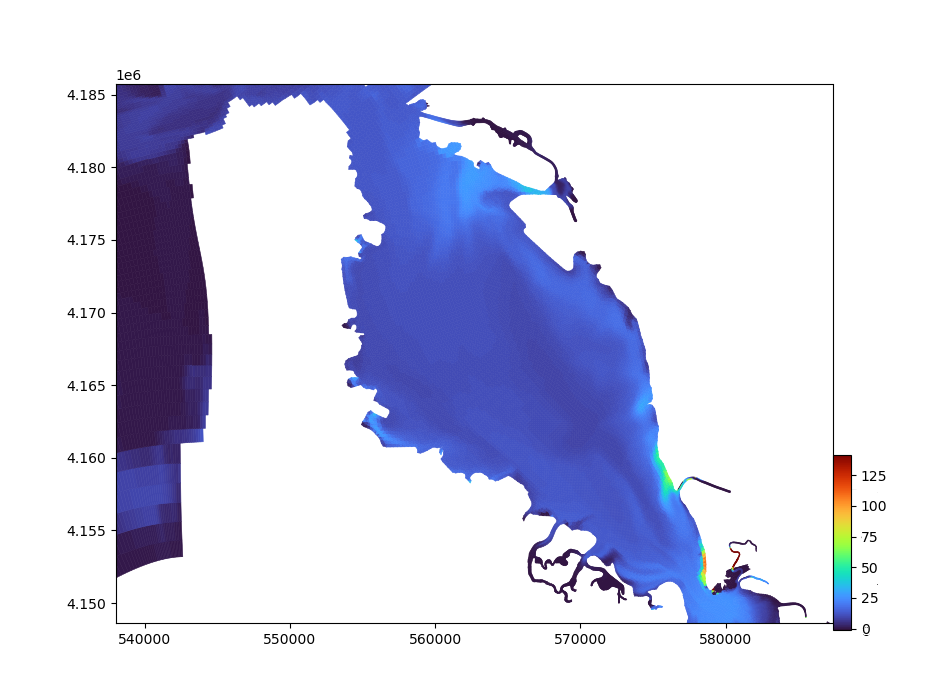

Checking for edge vars
edge dimension: edge


NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

Will update/create coordinate pane


In [202]:
from stompy.plot import nbviz
nbviz.NBViz([map_ds])
#fig,ax=plt.subplots()
#g.plot_cells(values)

DFM-based Runs
==

In [197]:
# restart files every 10 days, plus a restart file on 2022-08-01.
# speed was 85x realtime on 16 cores.
# Forcing should all be okay to copy/link for restarts.

if 1: # Check on map and rst output:
    dfm_base_run_dir="dfm_spinup"
    map_fn=os.path.join(dfm_base_run_dir,
                        "DFM_OUTPUT_wy2022_bloom_16layer",
                        "wy2022_bloom_16layer_0000_20220501_000000_map.nc")
    rst_fn=os.path.join(dfm_base_run_dir,
                        "DFM_OUTPUT_wy2022_bloom_16layer",
                        "wy2022_bloom_16layer_0000_20220801_000000_rst.nc")
    
map_ds=xr.open_dataset(map_fn)
rst_ds=xr.open_dataset(rst_fn)

In [ ]:
six.moves.reload_module(dfm)
import pdb

# First, get a basic restart going
class SFBRestartable(dfm.DFlowModel):
    """
    Add special sauce to symlink relevant forcing files that are
    not standard for dflow_model.
    This includes bc_files, src_files, meteo_coarse.grd
    """
    restart_copy_names=[] # symlink everything

    def copy_files_for_restart(self):
        super().copy_files_for_restart()
        prev_model=self.restart_from
        # Subdirectories are not automatically copied over, as well as meteo_coarse.grd
        for sub in ['bc_files','source_files','meteo_coarse.grd']:
            src=os.path.join(prev_model.run_dir,sub)
            if not os.path.exists(src):
                self.log.warning(f"Expected to symlink {src} but it wasn't there.")
                continue
            dst=os.path.join(self.run_dir,sub)
            if os.path.exists(dst):
                self.log.warning(f"Expected to make {dst} a copy or symlink but it already exists")
                continue

            if sub in self.restart_copy_names:
                self.log.info(f"Copy {src} => {dst}")
                shutil.copytree(src,dst)
            else:
                # Make the symlinks relative in all of this moves, is on a different machine, etc.
                src_rel=os.path.relpath(src,start=self.run_dir)
                self.log.info(f"Symlink {dst} => {src_rel}")
                os.symlink(src_rel,dst)        

prev_model=SFBRestartable.load(dfm_base_run_dir)

# for reference
class Rotoscope:
    """
    Common code for scene-to-scene remote sensed data
    """
    name="rotoscope_v01"
    
    swim_speeds=[0.0] # positive down.
    tracers_per_speed=['uniform','weight','weight_value']
    
    surface_xym=None # griddata-ready input to set the field
    

# And the remote sensed imagery part 
class DFMRotoscope(SFBRestartable,Rotoscope):
    name="rotodfm_v01"
    # Will start from the end of this existing run (which doesn't have the tracers)
    dfm_base_run_dir="dfm_spinup"
    scene_df=scene_df
    chl_clip=200 # clip large chl values
    
    copy_source_files=True # whether to copy or symlink source_files
    
    def run_scene_to_scene(self,start_scene_idx, stop_scene_idx):
        """
        Find a restart point close to start_scene_idx, 
        initialize, run to stop_scene_idx. If start_scene_idx is
        negative, skip tracer setup, just trying to get a restart file
        that matches stop_scene_idx, and assuming that the last 
        """
        # Find a suitable run to restart
        stop_time =self.scene_df.acquisition_start.values[stop_scene_idx]
        
        if start_scene_idx<0:
            prev_model=SFBRestartable.load(dfm_base_run_dir)            
            start_time=prev_model.restartable_time()
        else:
            start_time=scene_df.acquisition_start.values[start_scene_idx]
            prev_model=self.load_model_for_restart(start_time)            
        assert start_time < stop_time,f"Need to scan for restart time before scene stop time"
       
        # Setup a restart
        model=prev_model.create_restart(deep=True)
        model.run_stop=stop_time
        
        self.set_run_dir(model,start_scene_idx,stop_scene_idx)
        if start_scene_idx>=0:
            # populates self.tracers as a list of dictionaries
            # with ICs, names, etc.
            self.set_scene_tracers(model,start_scene_idx)
            
        self.generally_configure(model)
        model.write()
        # Wait until we have a starting ext file before updating it with
        # new tracers.
        self.add_tracers_to_bcs(model,self.tracers)
        model.partition()
        model.run_simulation()

    def generally_configure(self,model):
        model.mdu['output','WaqInterval']="" # no need for DWAQ output

        bloom_common.configure_dfm_t140737()
        model.dfm_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
        model.mpi_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
        
    def set_run_dir(self,model,start_scene_idx,stop_scene_idx):
        start_str,stop_str=[ utils.to_datetime(t).strftime("%Y%m%dT%H%M")
                            for t in [model.run_start,model.run_stop]]
        for x in range(20):
            run_dir=os.path.join(self.name,f"run_{start_str}_{stop_str}_v{x:02}")
            if not os.path.exists(run_dir): break
        else:
            raise Exception(f"Too many retries for {run_dir}")
        model.run_dir=run_dir

    def existing_runs(self):
        run_dirs=glob.glob(os.path.join(self.name,'run_*'))
        run_dirs.sort()
        return run_dirs
    
    def load_model_for_restart(self,start_time):
        # Get the run directories
        
        prev_model=None
        best_t_error=None # |seconds| between restart time and start_time
        
        check_runs=self.existing_runs() + [self.dfm_base_run_dir]
        
        for rd in self.existing_runs():
            model=SFBRestartable.load(rd)
            if not model.is_completed(): 
                continue
            t_restart=model.restartable_time()
            t_error=abs( (start_time - t_restart) / np.timedelta64(1,'s'))
            
            # Is this a good candidate for restarting?
            if (best_t_error is None) or (t_error<best_t_error):
                best_t_error=t_error
                prev_model=model
                
        assert prev_model is not None
        print(f"Found a restart: {prev_model.run_dir} error in start time {best_t_error}s")
        return prev_model

    def set_scene_tracers(self,model,start_scene_idx):
        # Deal with setting tracer fields.
        scene_xym=load_scene_utm(self.scene_df['xml'][start_scene_idx],clip=self.chl_clip)
        
        # I think the steps are
        #  1. add the tracer definitions to forcing data via appending/updating FlowFMold_bnd.ext
        #  2. add/overwrite the tracers in the restart file.
        
        tracers=[]
        
        for foo in ["bar"]:
            tracer_name='trace1'
            # for testing hack in gaussian blob
            def tracer_func(xyz):
                500*np.exp( -((xyz[:,:2]-np.r_[561470,4.16814e6])**2).sum(axis=-1)/1000**2)
            tracers.append( dict(name=tracer_name,func=tracer_func))
            
        # First tackle the case where the tracers do not already exist:
        self.tracers=tracers
        # Adding the tracers to the ext file doesn't happen until copy_file_for_restart
        # likewise, will have to modify the restart files later.
    
    def add_tracers_to_bcs(self,model,tracers):
        # take a more low-level approach compared to usual BC configuration
        # so that we can be very careful about what things change.
        ext_fn=model.mdu.filepath(('external forcing','ExtForceFile'))
        orig_ext_fn=ext_fn+".orig"
        # This check is more for dev -- it is fragile in the sense that if
        # orig_ext_fn *should* be different, we'll end up still using the
        # old file.
        if not os.path.exists(orig_ext_fn):
            shutil.copyfile(ext_fn,orig_ext_fn)

        bcs=model.parse_old_bc(orig_ext_fn)
        
        new_tracer_names=[t['name'] for t in tracers]
        configured_tracers={}
        
        # For now all boundary conditions for all new tracers are 0.
        # Note that establishing order here is very confusing. If these
        # need to be nonzero, it will take some work to know that 
        # it's correct. probably the strategy should be to filter out 
        # all existing BCs for these tracers, and then write them at the
        # end in our prescribed order.
        new_bc_values=[0.0 for t in tracers]

        def name_matches(cfg_name):
            for tracer in tracers:
                if tracer['name'].lower() == cfg_name.lower():
                    if tracer['name']!=cfg_name:
                        print(f"Careful - case mismatch {cfg_name} vs {tracer['name']}")
                    return True
            return False
            
        with open(ext_fn,'wt') as fp_new:
            for rec in bcs:
                write_verbatim=True
                
                quantity=rec['QUANTITY']
                if quantity.upper().startswith('INITIALTRACER'):
                    tracer_name=quantity[len("INITIALTRACER"):]
                    if name_matches(tracer_name): continue
                    # Tracer ICs we care about just because they help establish the
                    # list of tracers, but no need to change these entries.
                    # Actually, will just write out fresh stanzas for these in order
                    # to force the ordering.
                    # configured_tracers[tracer_name]=True
                elif quantity.upper().startswith('TRACERBND'):
                    tracer_name=quantity[len("TRACERBND"):]
                    if name_matches(tracer_name): continue
                    # And for now we leave boundary conditions as is, but again
                    # remember that this tracer has been configured.
                    #configured_tracers[tracer_name]=True
                elif quantity.upper().startswith('DISCHARGE_SALINITY_TEMPERATURE_SORSIN'):
                    print("Source/sink BC entry")
                    # Yuck - have to add new column(s). This only involves rewriting 
                    # the data file,though. The stanza is unchanged.
                    self.add_tracer_bcs(model,rec,new_values=new_bc_values,orig_num_values=3)

                # At this point nobody every changes the stanza, it's all written verbatim.
                if write_verbatim:
                    fp_new.write("\n".join(rec['stanza'])+"\n")
                    continue
                
            # And write out our new tracers (including ones that were skipped during 
            # transcription above
            for tracer in self.tracers:
                name=tracer['name']
                ic_fn=f"dummy-{name}.xyz"
                with open(os.path.join(model.run_dir,ic_fn),'wt') as fp_xyz:
                    fp_xyz.write("550000 4180000 0.0\n")
                fp_new.write("\n# NEW TRACERS\n"
                             f"QUANTITY=initialtracer{name}\n"
                             f"FILENAME={ic_fn}\n"
                             "FILETYPE=7\n"
                             "METHOD=5\n"
                             "OPERAND=O\n")
                                
    def add_tracer_bcs(self,model,bc,new_values=[],orig_num_values=3):
        """
        Add additional columns to a source/sink data file.
        So if the new run will include two dwaq tracers, pass new_values=[0,1]
        (which would tag sources with 0 for the first and 1.0 for the second)
        orig_num_values: 3 for run with salinity and temperature. I think
        less than that if temperature and/or salinity are disabled. 
        """
        # yuck...
        pli_fn=os.path.join(model.run_dir,bc['FILENAME'])
        assert pli_fn.lower().endswith('.pli')
        fn=pli_fn[:-4] + ".tim"
        assert os.path.exists(fn)
        fn_orig=fn+".orig"
        if not os.path.exists(fn_orig):
            shutil.copyfile(fn,fn_orig)
        data_orig=np.loadtxt(fn_orig)
        # drop previous forcing for new tracers. leaving time column and the original Q,S,T values
        columns=[data_orig[:,:1+orig_num_values]] 
        for new_val in new_values:
            columns.append( np.full(data_orig.shape[0],new_val))
        data=np.column_stack(columns)
        np.savetxt(fn,data,fmt="%.6g")

                        
roto=DFMRotoscope()
roto.run_scene_to_scene(0,1)


Found a restart: rotodfm_v01/run_20220801T0000_20220804T1812_v01 error in start time 1.0s


INFO:HydroModel:Could not find BC to get initial water level
INFO:DFlowModel:Writing MDU to rotodfm_v01/run_20220804T1812_20220805T1847_v03/wy2022_bloom_16layer.mdu
INFO:HydroModel:Symlink rotodfm_v01/run_20220804T1812_20220805T1847_v03/bc_files => ../run_20220801T0000_20220804T1812_v01/bc_files
INFO:HydroModel:Symlink rotodfm_v01/run_20220804T1812_20220805T1847_v03/source_files => ../run_20220801T0000_20220804T1812_v01/source_files
INFO:HydroModel:Symlink rotodfm_v01/run_20220804T1812_20220805T1847_v03/meteo_coarse.grd => ../run_20220801T0000_20220804T1812_v01/meteo_coarse.grd


Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry
Source/sink BC entry


INFO:HydroModel:Copying pre-partitioned grid files: rotodfm_v01/run_20220801T0000_20220804T1812_v01/sfei_v20_0000_net.nc => rotodfm_v01/run_20220804T1812_20220805T1847_v03/sfei_v20_0000_net.nc


Source/sink BC entry


INFO:HydroModel:Copying pre-partitioned grid files: rotodfm_v01/run_20220801T0000_20220804T1812_v01/sfei_v20_0001_net.nc => rotodfm_v01/run_20220804T1812_20220805T1847_v03/sfei_v20_0001_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: rotodfm_v01/run_20220801T0000_20220804T1812_v01/sfei_v20_0002_net.nc => rotodfm_v01/run_20220804T1812_20220805T1847_v03/sfei_v20_0002_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: rotodfm_v01/run_20220801T0000_20220804T1812_v01/sfei_v20_0003_net.nc => rotodfm_v01/run_20220804T1812_20220805T1847_v03/sfei_v20_0003_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: rotodfm_v01/run_20220801T0000_20220804T1812_v01/sfei_v20_0004_net.nc => rotodfm_v01/run_20220804T1812_20220805T1847_v03/sfei_v20_0004_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: rotodfm_v01/run_20220801T0000_20220804T1812_v01/sfei_v20_0005_net.nc => rotodfm_v01/run_20220804T1812_20220805T1847_v03/sfei_v20_0005_net.nc
INFO:HydroModel:Copying pre-partiti

In [191]:
model=prev_model.create_restart(deep=True)
# data_dfm_rs_restart0 was using dfm_spinup
# data_dfm_rs2_restart0 is a test with dfm_spinup_repartition 
model.run_dir="data_dfm_rs_restart0" 

In [192]:
# run_start is already set from the end of prev_model.
# Testing with a 1 day run:
model.run_stop = model.run_start + np.timedelta64(1,'D')
model.mdu['output','WaqInterval']="" # no need for DWAQ output on these.
# model.mdu['numerics','Tlfsmo'] = 0.0 # no longer allowed for restart. this is now handled in stompy

# This fixeds the flownodes issue. Now handled by stompy
# model.mdu['geometry','RenumberFlowNodes']=0

In [193]:
import bloom_common
six.moves.reload_module(bloom_common)
bloom_common.configure_dfm_t140737()
model.dfm_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
model.mpi_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')

In [194]:
model.write()

INFO:HydroModel:Could not find BC to get initial water level
INFO:DFlowModel:Writing MDU to data_dfm_rs_restart0/wy2022_bloom_16layer.mdu


In [195]:
model.partition()

INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0000_net.nc => data_dfm_rs_restart0/sfei_v20_0000_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0001_net.nc => data_dfm_rs_restart0/sfei_v20_0001_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0002_net.nc => data_dfm_rs_restart0/sfei_v20_0002_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0003_net.nc => data_dfm_rs_restart0/sfei_v20_0003_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0004_net.nc => data_dfm_rs_restart0/sfei_v20_0004_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0005_net.nc => data_dfm_rs_restart0/sfei_v20_0005_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0006_net.nc => data_dfm_rs_restart0/sfei_v20_0006_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0007_net.nc => data_dfm_r

b"Scattering original MDU file 'wy2022_bloom_16layer.mdu' across partitioned files...\n #0: wy2022_bloom_16layer_0000.mdu\n #1: wy2022_bloom_16layer_0001.mdu\n #2: wy2022_bloom_16layer_0002.mdu\n #3: wy2022_bloom_16layer_0003.mdu\n #4: wy2022_bloom_16layer_0004.mdu\n #5: wy2022_bloom_16layer_0005.mdu\n #6: wy2022_bloom_16layer_0006.mdu\n #7: wy2022_bloom_16layer_0007.mdu\n #8: wy2022_bloom_16layer_0008.mdu\n #9: wy2022_bloom_16layer_0009.mdu\n #10: wy2022_bloom_16layer_0010.mdu\n #11: wy2022_bloom_16layer_0011.mdu\n #12: wy2022_bloom_16layer_0012.mdu\n #13: wy2022_bloom_16layer_0013.mdu\n #14: wy2022_bloom_16layer_0014.mdu\n #15: wy2022_bloom_16layer_0015.mdu\n"

In [196]:
model.run_simulation()

INFO:HydroModel:Running command: /opt/software/delft/dfm/t140737/bin/mpiexec -n 16 /opt/software/delft/dfm/t140737/bin/dflowfm -t 1 --autostartstop wy2022_bloom_16layer.mdu


In [200]:
scene_df

,xml,acquisition_start,acquisition_stop
0,rs_chl/04b_log10/20220804_BandMath_BandMath.dim,2022-08-04 18:12:01,2022-08-04 18:12:20
1,rs_chl/04b_log10/20220805_BandMath_BandMath.dim,2022-08-05 18:47:14,2022-08-05 18:47:33
2,rs_chl/04b_log10/20220806_BandMath_BandMath.dim,2022-08-06 18:21:23,2022-08-06 18:21:42
3,rs_chl/04b_log10/20220807_BandMath_BandMath.dim,2022-08-07 17:55:28,2022-08-07 17:55:46
4,rs_chl/04b_log10/20220808_BandMath_BandMath.dim,2022-08-08 18:08:18,2022-08-08 18:08:37
5,rs_chl/04b_log10/20220809_BandMath_BandMath.dim,2022-08-09 18:43:32,2022-08-09 18:43:51
6,rs_chl/04b_log10/20220810_BandMath_BandMath.dim,2022-08-10 18:17:41,2022-08-10 18:18:00
7,rs_chl/04b_log10/20220811_BandMath_BandMath.dim,2022-08-11 18:30:30,2022-08-11 18:30:49
8,rs_chl/04b_log10/20220812_BandMath_BandMath.dim,2022-08-12 18:04:36,2022-08-12 18:04:54
9,rs_chl/04b_log10/20220813_BandMath_BandMath.dim,2022-08-13 18:39:52,2022-08-13 18:40:11
